In [6]:
import torch
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# Load the Faster-RCNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [39]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter',
    'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
    'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet',
    'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [27]:
# Function to load the image
def load_image(image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    return transform(image).unsqueeze(0)     # Add the batch dimension

In [28]:
load_image('puppy.jpg')

tensor([[[[0.9412, 0.9412, 0.9412,  ..., 0.8941, 0.8980, 0.9059],
          [0.9412, 0.9412, 0.9451,  ..., 0.8941, 0.8941, 0.8980],
          [0.9333, 0.9373, 0.9373,  ..., 0.8941, 0.8902, 0.8902],
          ...,
          [0.2235, 0.2471, 0.2627,  ..., 0.2706, 0.2627, 0.2667],
          [0.2039, 0.2196, 0.2314,  ..., 0.2353, 0.2275, 0.2314],
          [0.2118, 0.2235, 0.2314,  ..., 0.2431, 0.2392, 0.2431]],

         [[0.9294, 0.9294, 0.9294,  ..., 0.8824, 0.8863, 0.8941],
          [0.9294, 0.9294, 0.9333,  ..., 0.8824, 0.8824, 0.8863],
          [0.9216, 0.9255, 0.9255,  ..., 0.8824, 0.8784, 0.8784],
          ...,
          [0.1451, 0.1686, 0.1843,  ..., 0.1686, 0.1608, 0.1647],
          [0.1255, 0.1412, 0.1529,  ..., 0.1333, 0.1255, 0.1294],
          [0.1333, 0.1451, 0.1529,  ..., 0.1412, 0.1373, 0.1412]],

         [[0.8549, 0.8549, 0.8549,  ..., 0.7608, 0.7569, 0.7647],
          [0.8549, 0.8549, 0.8588,  ..., 0.7608, 0.7529, 0.7569],
          [0.8549, 0.8588, 0.8588,  ..., 0

In [32]:
# Define function for prediction
def predict(image):
  image_tensor = load_image(image)
  with torch.no_grad():
     predictions = model(image_tensor)
  return predictions

In [49]:
from textwrap import fill
# To visualize the prediction
def visualize_prediction(image, predictions):
  image = plt.imread(image)  # reading or coverting into array
  plt.imshow(image)

  # extracting the boxes, labels and scores
  boxes = predictions[0]['boxes']
  labels = predictions[0]['labels']
  scores = predictions[0]['scores']

  # Filtering only having probability higher than 0.5
  keep = scores > 0.5
  boxes = boxes[keep]
  labels = labels[keep]

  # Exception handling for index range


  for box, label in zip(boxes, labels):
    box = box.cpu().numpy()
    x_min, y_min, x_max, y_max = box
    plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, edgecolor='red', linewidth=2, fill =False))

    plt.text(x_min, y_min - 3, f'class: {COCO_INSTANCE_CATEGORY_NAMES[label.item() - 1]}', color='red')


  plt.show()



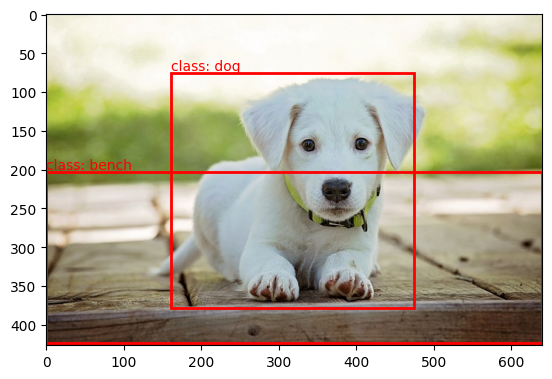

In [50]:
predictions = predict('puppy.jpg')
visualize_prediction('puppy.jpg', predictions)

IndexError: list index out of range

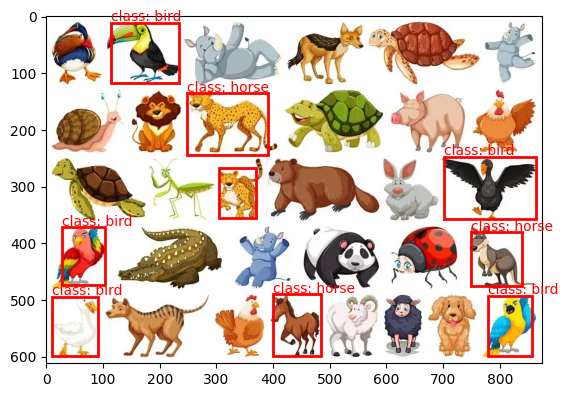

In [51]:
predictions = predict('100-wild-animals.webp')
visualize_prediction('100-wild-animals.webp', predictions)


IndexError: list index out of range

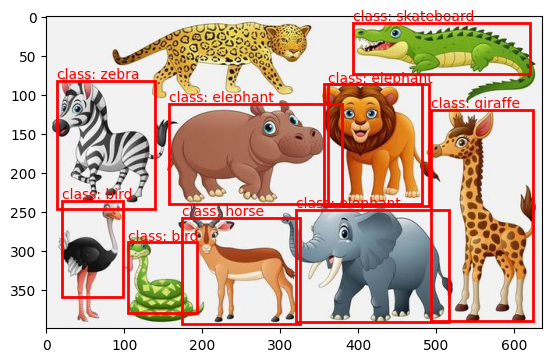

In [52]:
predictions = predict('cartoon-animals.jpg')
visualize_prediction('cartoon-animals.jpg', predictions)
